# Clustering
## by Vitalii Novikov

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples


In [18]:

dat = pd.read_csv('iris.csv')

print(dat.head())

df0 = dat[['Sepal.Length', 'Sepal.Width']]


   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


## Normalizing data


In [19]:
scaler_2 = StandardScaler()
df0_scaled = scaler_2.fit_transform(df0)

## K-means algorithm

### Elbow plot

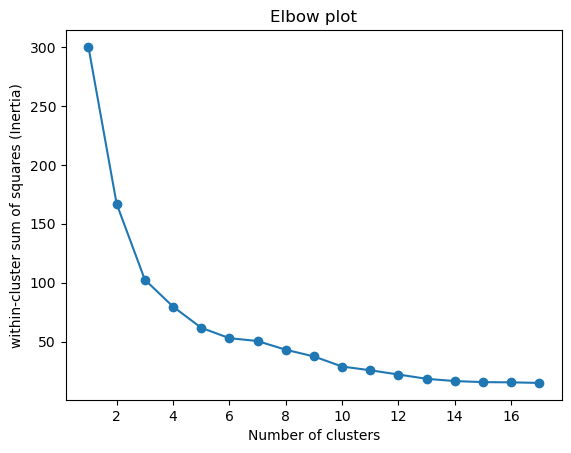

In [20]:

inertia = []
k_range = range(1, 18)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=2)
    kmeans.fit(df0_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title('Elbow plot')
plt.xlabel('Number of clusters')
plt.ylabel('within-cluster sum of squares (Inertia)')
plt.show()


Significant decrease of within-cluster sum of squares can be seen at the first and second step (2 and 3 clusters respectively). May be these numbers  can be recognized as good number of clusters.

A large number of clusters can cause each data point to be recognized as a distinct cluster, which doesn't make sense.

### Silhouette plot

Silhouette values and their approx. meaning:
- 1.0 – 0.71: well clustered samples, clustering found strong structures
- 0.7 – 0.51: medium and somewhat acceptable structures were found
- 0.5 – 0.26: weak structures
- <0.25: no substantial structures were found, and samples lie
between clusters


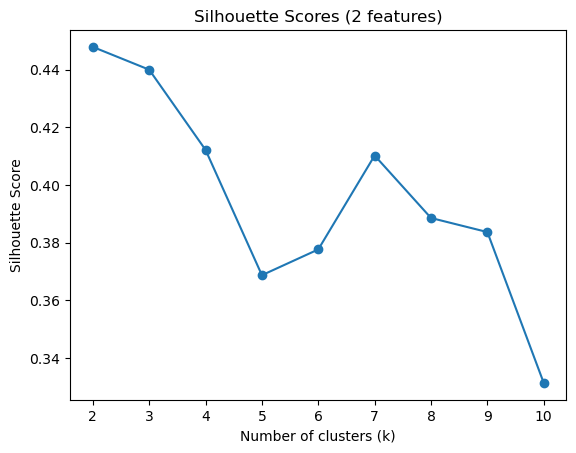

In [21]:

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=10)
    labels = kmeans.fit_predict(df0_scaled)
    score = silhouette_score(df0_scaled, labels)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores (2 features)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


Since we would like to maximize Silhouette score, which is  (b - a) / max(a, b) where (a) is “mean intra-cluster distance” and (b) is “mean nearest-cluster distance”.

If we consider  approximate meaning described before as a rule of thumb, then our best clustering can be described as "weak structure".

The detailed Silhouette plot of the best structure:

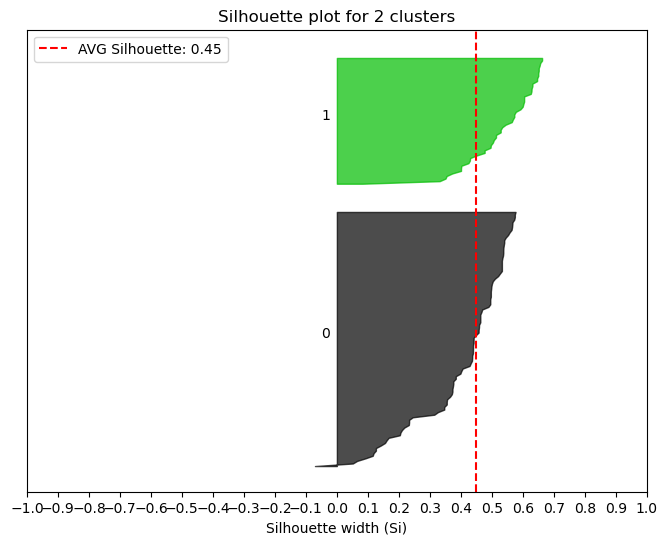

In [22]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = kmeans.fit_predict(df0_scaled)

silhouette_avg = silhouette_score(df0_scaled, cluster_labels)
sample_silhouette_values = silhouette_samples(df0_scaled, cluster_labels)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

# (n_clusters + 1) * 10 - some space between clusters at plot
ax1.set_ylim([0, len(df0_scaled) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax1.set_title(f"Silhouette plot for {n_clusters} clusters")
ax1.set_xlabel("Silhouette width (Si)")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"AVG Silhouette: {silhouette_avg:.2f}")
ax1.legend()

ax1.set_yticks([])
ax1.set_xticks(np.arange(-1, 1.1, 0.1))
plt.show()

There is an observation in the gray cluster that is closer to another cluster. Also gray cluster mainly consist of observations with Silhouette width <0.5, which underlines the "weak structure".

But this structure is the best that the K-mean clustering can produce.

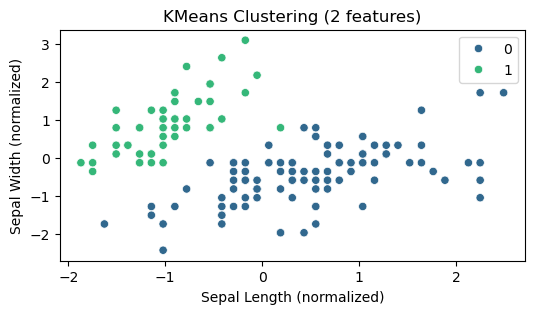

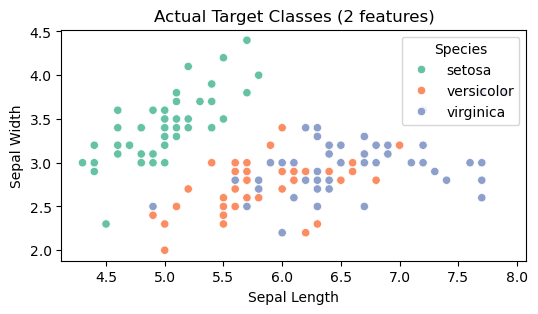

In [23]:

# Visualization
plt.figure(figsize=(6, 3))
sns.scatterplot(x=df0_scaled[:, 0], y=df0_scaled[:, 1], hue=cluster_labels, palette='viridis')
plt.title('KMeans Clustering (2 features)')
plt.xlabel('Sepal Length (normalized)')
plt.ylabel('Sepal Width (normalized)')
plt.show()

# Actual classes
plt.figure(figsize=(6, 3))
sns.scatterplot(x=df0.iloc[:, 0], y=df0.iloc[:, 1], hue=dat['Species'], palette='Set2')
plt.title('Actual Target Classes (2 features)')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()


Well, the actual valueas include 3 classes, which already a mistake of classification. But "setosa" class is very close to recognized cluster with K-means algorithm, whereas still has some mistakes.

The "versicolor" and "virginica" classes are placed together with a huge overlap in terms of chosen variables (only 2 dimentions). Therefore, it is impossible for K-means to distinguish these observations.

## Gaussian Mixture Models (2 variables)

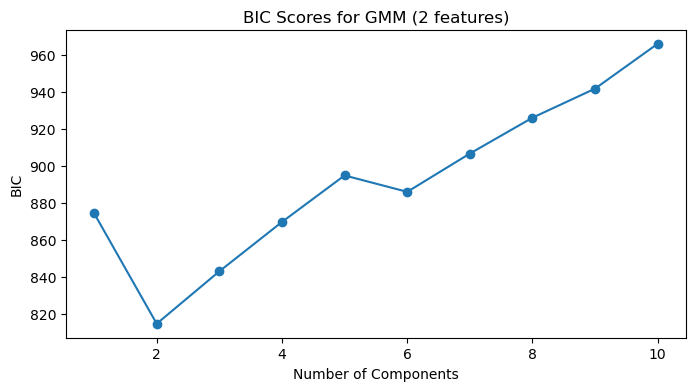

Best number of components for GMM (2 features): 2


In [24]:
bic_scores = []

for k in range(1, 11):
    gmm = GaussianMixture(n_components=k, random_state=1)
    gmm.fit(df0_scaled)
    bic_scores.append(gmm.bic(df0_scaled))

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), bic_scores, marker='o')
plt.title('BIC Scores for GMM (2 features)')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.show()

best_k = np.argmin(bic_scores) + 1
print(f'Best number of components for GMM (2 features): {best_k}')


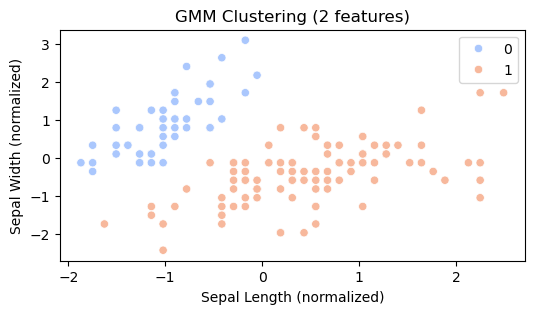

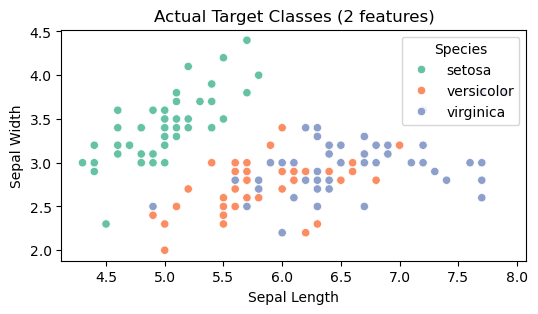

In [25]:

gmm_best = GaussianMixture(n_components=best_k, random_state=20)
labels_gmm = gmm_best.fit_predict(df0_scaled)

# Visualization
plt.figure(figsize=(6, 3))
sns.scatterplot(x=df0_scaled[:, 0], y=df0_scaled[:, 1], hue=labels_gmm, palette='coolwarm')
plt.title('GMM Clustering (2 features)')
plt.xlabel('Sepal Length (normalized)')
plt.ylabel('Sepal Width (normalized)')
plt.show()

# Actual classes
plt.figure(figsize=(6, 3))
sns.scatterplot(x=df0.iloc[:, 0], y=df0.iloc[:, 1], hue=dat['Species'], palette='Set2')
plt.title('Actual Target Classes (2 features)')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

GaussianMixture devide into clusters in the similar manner. But there is just 1 mistake in recognizing "setosa", whereas K-means had 2 mistakes.

The difference in the vertex (6.0 , 3.4) - or (0.1, 0.7) in standard scale.

## Clustering with 4 features in the iris data set

In [26]:
dat.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


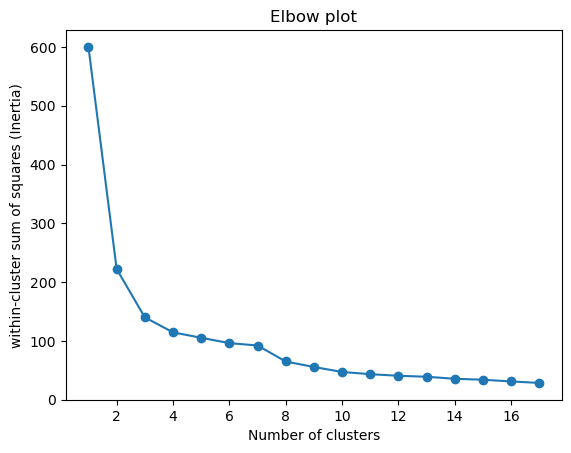

In [27]:

scaler = StandardScaler()
dat_scaled = scaler.fit_transform(dat.iloc[:,0:4])

inertia = []
k_range = range(1, 18)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=2)
    kmeans.fit(dat_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title('Elbow plot')
plt.xlabel('Number of clusters')
plt.ylabel('within-cluster sum of squares (Inertia)')
plt.show()


Again it makes sense to take 2 or 3 as number of clusters.

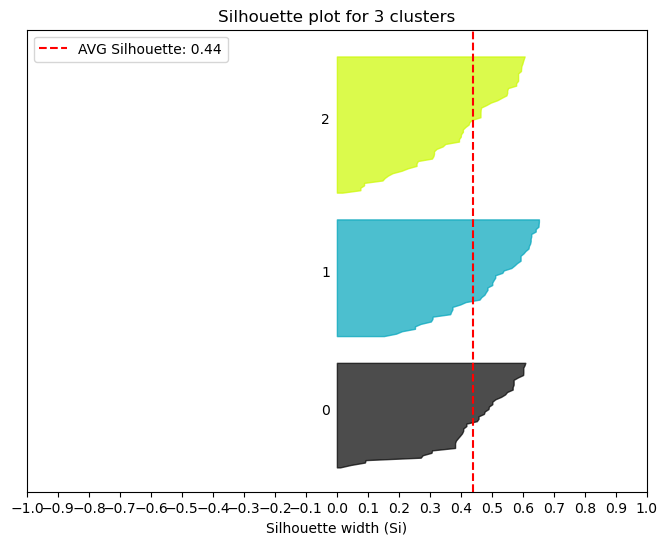

In [28]:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = kmeans.fit_predict(df0_scaled)

silhouette_avg = silhouette_score(df0_scaled, cluster_labels)
sample_silhouette_values = silhouette_samples(df0_scaled, cluster_labels)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

# (n_clusters + 1) * 10 - some space between clusters at plot
ax1.set_ylim([0, len(df0_scaled) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax1.set_title(f"Silhouette plot for {n_clusters} clusters")
ax1.set_xlabel("Silhouette width (Si)")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"AVG Silhouette: {silhouette_avg:.2f}")
ax1.legend()

ax1.set_yticks([])
ax1.set_xticks(np.arange(-1, 1.1, 0.1))
plt.show()

We got even lower AVG Silhouette score (0.45 -> 0.44), but in this case all data-points have positive Silhouette width, which means that they belong to the closest cluster's centre.

### Why we didn't get better results? (compared to previous K-mean)

Simply, the K-means clustering recognize clusters based on spacial distance. In iris data some of metrics are similar among classes, which makes it dificult to distinguish them. 

I think even in 4d space there are some data-points that makes overlap within classes. That's why the K-mean method cannot be ensure that some  data-points should be belonged to particular cluster (such data-points has low Silhouette width).

Moreover, high-dimensional data can be noisy and harder to cluster because of the "curse of dimensionality."



### Visualization

The same dimentions as before used to visualize recognized clusters (but it trained on 4 variables)

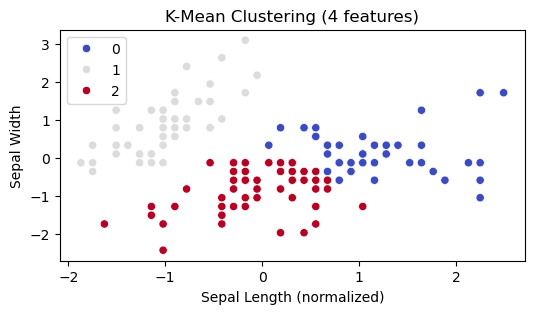

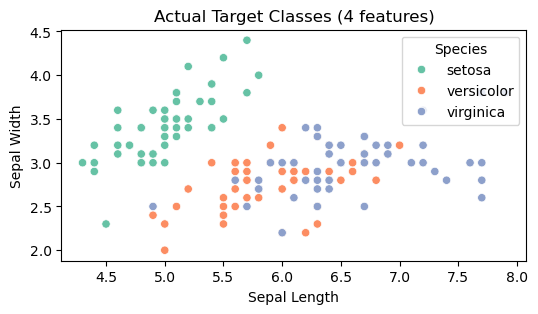

In [29]:
plt.figure(figsize=(6, 3))
sns.scatterplot(x=dat_scaled[:, 0], y=dat_scaled[:, 1], hue=cluster_labels, palette='coolwarm')
plt.title('K-Mean Clustering (4 features)')
plt.xlabel('Sepal Length (normalized)')
plt.ylabel('Sepal Width')
plt.show()

# Actual classes
plt.figure(figsize=(6, 3))
sns.scatterplot(x=dat.iloc[:, 0], y=dat.iloc[:, 1], hue=dat['Species'], palette='Set2')
plt.title('Actual Target Classes (4 features)')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

## Gaussian Mixture Models (4 variables)

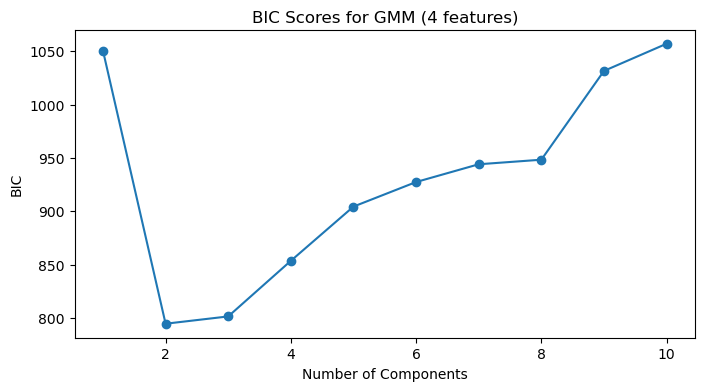

Best number of components for GMM (4 features): 2


In [30]:
bic_scores = []

for k in range(1, 11):
    gmm = GaussianMixture(n_components=k, random_state=1)
    gmm.fit(dat_scaled)
    bic_scores.append(gmm.bic(dat_scaled))

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), bic_scores, marker='o')
plt.title('BIC Scores for GMM (4 features)')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.show()

best_k = np.argmin(bic_scores) + 1
print(f'Best number of components for GMM (4 features): {best_k}')

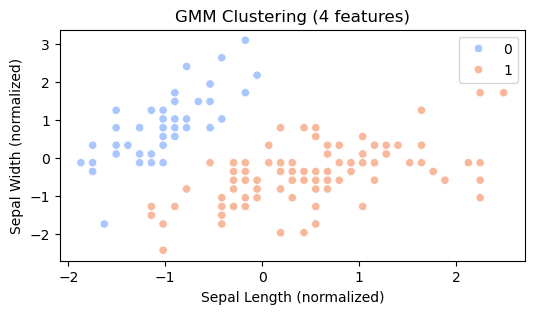

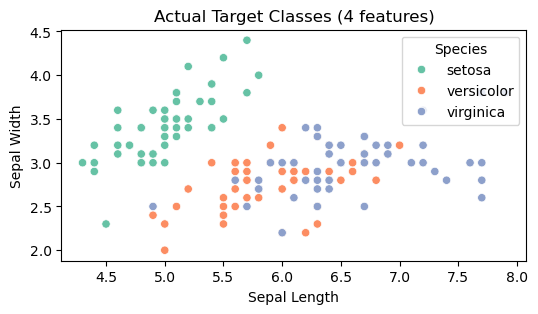

In [31]:
gmm_best = GaussianMixture(n_components=best_k, random_state=20)
labels_gmm = gmm_best.fit_predict(dat_scaled)

# Visualization
plt.figure(figsize=(6, 3))
sns.scatterplot(x=dat_scaled[:, 0], y=dat_scaled[:, 1], hue=labels_gmm, palette='coolwarm')
plt.title('GMM Clustering (4 features)')
plt.xlabel('Sepal Length (normalized)')
plt.ylabel('Sepal Width (normalized)')
plt.show()

# Actual classes
plt.figure(figsize=(6, 3))
sns.scatterplot(x=dat.iloc[:, 0], y=dat.iloc[:, 1], hue=dat['Species'], palette='Set2')
plt.title('Actual Target Classes (4 features)')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

Selection procedure based on BIC suggest to stick with k=2 even for 4 variables.

At plots we can see, that the "setosa" class correctly distinguished as cluster.

## How to impove results?

1) Use Petal features instead of Sepal features, because the former are more helpful, whereas the later brings "noise" to clustering algorithms. (I trained and visualized K-Means on Petal features below, it showed much better result),

2) Another possible method is to use other Clustering algorithms, like DBSCAN, but it will needed to tune hyperparametres. (I tried a little bit, but the most appropriate picture are far away from actual classes).

3) In real case examples usually we should chose among a lot of features, so sometimes it can be helpful to use other combinations of features or even create new features (like proxies) that can meaningfully describe the differences of clusters.

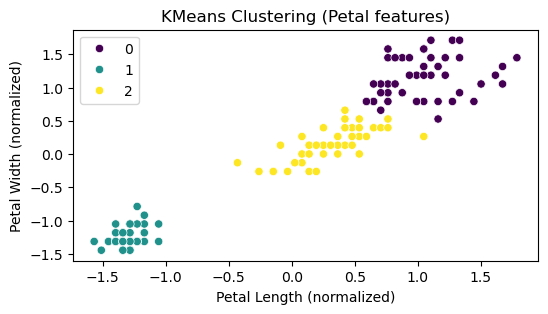

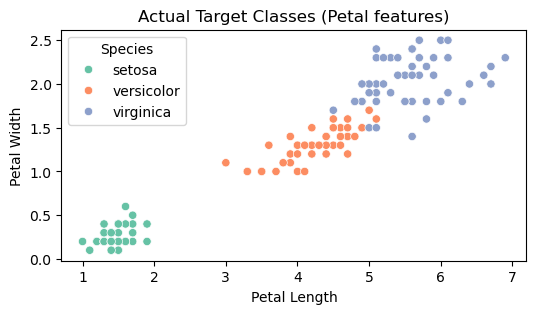

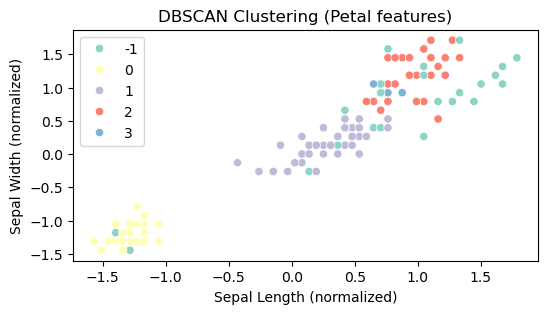

In [32]:
df1 = dat[['Petal.Length', 'Petal.Width']]
scaler_ = StandardScaler()
df1_scaled = scaler_.fit_transform(df1)
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = kmeans.fit_predict(df1_scaled)


# Visualization K-Means 
plt.figure(figsize=(6, 3))
sns.scatterplot(x=df1_scaled[:, 0], y=df1_scaled[:, 1], hue=cluster_labels, palette='viridis')
plt.title('KMeans Clustering (Petal features)')
plt.xlabel('Petal Length (normalized)')
plt.ylabel('Petal Width (normalized)')
plt.show()

# Actual classes
plt.figure(figsize=(6, 3))
sns.scatterplot(x=dat.iloc[:, 2], y=dat.iloc[:, 3], hue=dat['Species'], palette='Set2')
plt.title('Actual Target Classes (Petal features)')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()

eps = 0.35
min_samples = 4

# DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(dat_scaled[:, 1:4])

# Visualization DBSCAN
plt.figure(figsize=(6, 3))
sns.scatterplot(x=dat_scaled[:, 2], y=dat_scaled[:, 3], hue=clusters, palette='Set3')
plt.title('DBSCAN Clustering (Petal features)')
plt.xlabel('Sepal Length (normalized)')
plt.ylabel('Sepal Width (normalized)')
plt.show()
